# **Spatial-Spectral Summarizer Fusion Network (S³F-Net) Spectral Baseline (SpectraNet) Implementation**

This notebook contains the full implementation of **SpectraNet** on the BRISC 2025 (Brain MRI Segmentation and Classification) dataset. We use the **SpectraNet-1** variant here, for comparisons with **S³F-Net** and the Baseline Spatial CNN. The full architecture is customizable, feel free to do so. Edit the file paths according to your setup.

## **Data Preparation**

In [ ]:
# ==============================================================================
# BLOCK 1: SETUP, IMPORTS AND DATA LOADING (FOR BRISC2025)
# ==============================================================================
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup ---
print("--- Mounting Google Drive ---")
drive.mount('/content/drive')

# --- Configuration ---
IMG_SIZE = (256, 256)
BATCH_SIZE = 16
EPOCHS = 200
RANDOM_STATE = 42

# --- Paths ---
DATASET_PATH = "/content/drive/MyDrive/Medical Image Segmentation/BRISC 2025 Dataset/classification_task"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
TEST_PATH = os.path.join(DATASET_PATH, "test")
SAVE_FOLDER = "/content/drive/MyDrive/S3F_Net_Models"
os.makedirs(SAVE_FOLDER, exist_ok=True)
CLASSIFIER_MODEL_PATH = os.path.join(SAVE_FOLDER, "SpectraNet_1_BRISC.keras")

In [ ]:
# ==============================================================================
# BLOCK 2: DATA LOADING AND PREPROCESSING FOR BRISC2025
# ==============================================================================
def load_data_from_folders(folder_path):
    """
    Loads images and labels from a folder structured with pre-defined class subdirectories (The kind we have for BRISC2025).
    (e.g., .../train/glioma/, .../train/meningioma/, etc.)
    """
    images, labels = [], []
    # Sorting the class names to ensure consistent mapping (e.g., glioma is always 0)
    class_names = sorted(os.listdir(folder_path))
    class_map = {name: i for i, name in enumerate(class_names)}

    print(f"Loading data from: {folder_path}")
    print(f"Found classes: {class_names} -> Mapped to: {class_map}")

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path): continue

        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None: continue
                img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
                img = img.astype('float32') / 255.0
                images.append(img[..., np.newaxis])
                labels.append(class_map[class_name])
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue

    # Shuffling the data to ensure randomness
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images = np.array(images)[indices]
    labels = np.array(labels)[indices]

    return images, labels, class_names

# --- Loading Data from Train and Test Folders ---
try:
    X_train, y_train, CLASS_NAMES = load_data_from_folders(TRAIN_PATH)
    X_test, y_test, _ = load_data_from_folders(TEST_PATH)

    print(f"\nTraining data loaded: {len(X_train)} samples")
    print(f"Test data loaded: {len(X_test)} samples")

    # Calculating class weights for handling any imbalance in the training set
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))
    print(f"\nCalculated class weights: {class_weights_dict}")

except Exception as e:
    print(f"Failed to load dataset: {e}")
    exit()

Loading data from: /content/drive/MyDrive/Medical Image Segmentation/BRISC 2025 Dataset/classification_task/train
Found classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary'] -> Mapped to: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
Loading data from: /content/drive/MyDrive/Medical Image Segmentation/BRISC 2025 Dataset/classification_task/test
Found classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary'] -> Mapped to: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}

Training data loaded: 5000 samples
Test data loaded: 1010 samples

Calculated class weights: {0: np.float64(1.0897994768962511), 1: np.float64(0.9405568096313017), 2: np.float64(1.1715089034676665), 3: np.float64(0.8579272477693891)}


## **SpectraNet-1 Model Building**

In [2]:
# ==============================================================================
# BLOCK 3: MODEL ARCHITECTURE (SpectraNet with 1 SpectralFilter Layer)
# ==============================================================================
# This block defines the SpectraNet-1 Architecture

# --- Custom SpectralFilter Layer & Encoders ---
class SpectralFilterLayer(layers.Layer):
    def __init__(self, filters, **kwargs): super().__init__(**kwargs); self.filters = filters
    def build(self, input_shape):
        _, h, w, c = input_shape
        fft_shape = (h, w // 2 + 1)
        self.real_weights = self.add_weight(name='real_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.imag_weights = self.add_weight(name='imag_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.bias = self.add_weight(name='bias', shape=(self.filters,), initializer='zeros')
    def call(self, inputs):
        inputs_p = tf.transpose(inputs, [0, 3, 1, 2])
        inputs_fft = tf.signal.rfft2d(inputs_p)
        kernel_fft = tf.complex(self.real_weights, self.imag_weights)
        output_fft = tf.einsum('bchw,cfhw->bfhw', inputs_fft, kernel_fft)
        output_s = tf.signal.irfft2d(output_fft)
        output_p = tf.transpose(output_s, [0, 2, 3, 1])
        return output_p + self.bias
    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.filters})
        return config

def depthwise_sep_block(x, filters, kernel_size=3, strides=1):
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def build_spectral_summary_branch(inputs):
    x = SpectralFilterLayer(32)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = depthwise_sep_block(x, 64)
    x = layers.MaxPooling2D(2)(x)

    x = depthwise_sep_block(x, 128)
    x = layers.MaxPooling2D(2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1875)(x)
    x = layers.Dense(4, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3125)(x)

    return x

# --- SpectraNet Model Builder ---
def build_spectral_only_classifier(input_shape, num_classes):
    """Builds the SpectraNet-1 model for classification."""
    inputs = layers.Input(input_shape)

    # 1. Building the spectral summary branch
    spectral_vector = build_spectral_summary_branch(inputs)

    # 2. Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(spectral_vector)

    model = models.Model(inputs, outputs, name="SpectraNet_1_Classifier")

    # Compiling with the same optimizer and CE loss as S³F-Net
    model.compile(optimizer=optimizers.Adam(0.0003),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("SpectraNet model architecture is ready.")

SpectraNet model architecture is ready.


## **Model Training**

In [ ]:
# ==============================================================================
# BLOCK 4: CUSTOM CALLBACK AND TRAINING
# ==============================================================================
from sklearn.metrics import f1_score

# --- Custom F1 Score Callback to use 'weighted' average ---
class F1ScoreCallback(callbacks.Callback):
    def __init__(self, validation_data, filepath, patience=25):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.filepath = filepath
        self.patience = patience
        self.best_f1 = -1.0
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred_proba = self.model.predict(X_val, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)

        weighted_f1 = f1_score(y_val, y_pred, average='weighted')
        logs['val_f1_weighted'] = weighted_f1

        print(f" - val_f1_weighted: {weighted_f1:.4f}", end="")

        if weighted_f1 > self.best_f1:
            print(f" (New best F1, saving model to {self.filepath})")
            self.best_f1 = weighted_f1
            self.model.save(self.filepath)
            self.wait = 0
        else:
            print()
            self.wait += 1
            if self.wait >= self.patience:
                print("Early stopping triggered based on weighted F1-score.")
                self.model.stop_training = True

# --- Defining the model path ---
CLASSIFIER_MODEL_PATH = os.path.join(SAVE_FOLDER, "SpectraNet_1_BRISC.keras")

# --- Building the Model ---
print("\n--- Building SpectraNet ---")
classifier_model = build_spectral_only_classifier(X_train.shape[1:], num_classes=len(CLASS_NAMES))

# --- Compiling the model with standard cross-entropy ---
classifier_model.compile(optimizer=optimizers.Adam(0.0003),
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])
classifier_model.summary()

# --- Defining Callbacks ---
f1_callback = F1ScoreCallback(validation_data=(X_test, y_test),
                              filepath=CLASSIFIER_MODEL_PATH,
                              patience=40)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=20,
                                        min_lr=1e-6,
                                        verbose=1)

# --- Training the Model ---
print("\n--- Training (Monitoring Weighted F1-Score) ---")
history = classifier_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[f1_callback, reduce_lr]
)

print("\n--- Training Finished ---")


--- Building Spectral-Only Classifier for BRISC2025 ---


Model: "Spectral_Only_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_conv_layer_2           │ (None, 256, 256, 32)   │     2,113,568 │
│ (SpectralConvLayer)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 256, 256, 32)   │           288 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 256, 256, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 128, 128, 64)   │           576 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 128)  │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,128,184 (8.12 MB)

 Trainable params: 2,127,504 (8.12 MB)

 Non-trainable params: 680 (2.66 KB)


--- Training Spectral-Only Baseline on BRISC2025 ---
Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4693 - loss: 1.1990 - val_f1_weighted: 0.1565 (New best F1, saving model to /content/drive/MyDrive/S2F_Net_Models/spectral_only_BRISC.keras)
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.4695 - loss: 1.1988 - val_accuracy: 0.3119 - val_loss: 1.3493 - val_f1_weighted: 0.1565 - learning_rate: 3.0000e-04
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6152 - loss: 0.9717 - val_f1_weighted: 0.2750 (New best F1, saving model to /content/drive/MyDrive/S2F_Net_Models/spectral_only_BRISC.keras)
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6153 - loss: 0.9716 - val_accuracy: 0.3931 - val_loss: 1.3054 - val_f1_weighted: 0.2750 - learning_rate: 3.0000e-04
Epoch 3/200
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6766 - loss: 0.8424 - val_f1_weighted: 0.2809 (New best F1, saving model to /content/drive/MyDrive/S2F_Net_Models/s

## **Evaluation**



--- Final Evaluation of Spectral-Only Baseline on BRISC2025 Test Set ---
Loading best model from: /content/drive/MyDrive/S2F_Net_Models/spectral_only_BRISC.keras

--- Calculating Loss and Accuracy on Test Set ---
Test Loss:      0.1911
Test Accuracy:  0.9446
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step

--- Detailed Performance Metrics ---
Macro F1 Score:   0.9478
Weighted F1 Score:0.9442
Cohen's Kappa:    0.9243
MCC:              0.9244
AUC-ROC (Macro):  0.9923
AUC-ROC (Weighted):0.9912

--- Classification Report ---
              precision    recall  f1-score   support

      glioma     0.9213    0.9213    0.9213       254
  meningioma     0.9320    0.8954    0.9133       306
    no_tumor     0.9589    1.0000    0.9790       140
   pituitary     0.9684    0.9871    0.9776       310

    accuracy                         0.9446      1010
   macro avg     0.9451    0.9509    0.9478      1010
weighted avg     0.9442    0.9446    0.9442      1010



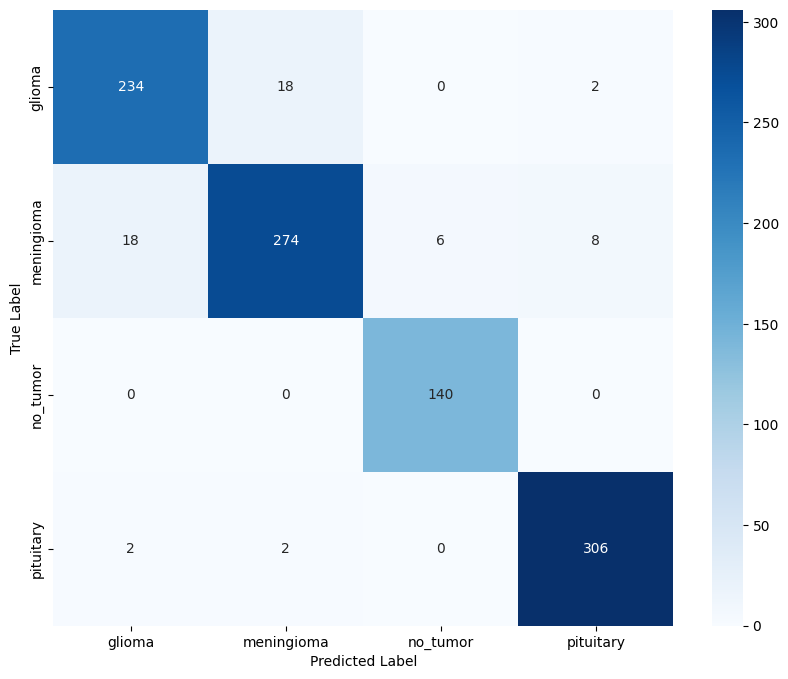


--- Training History Plots ---


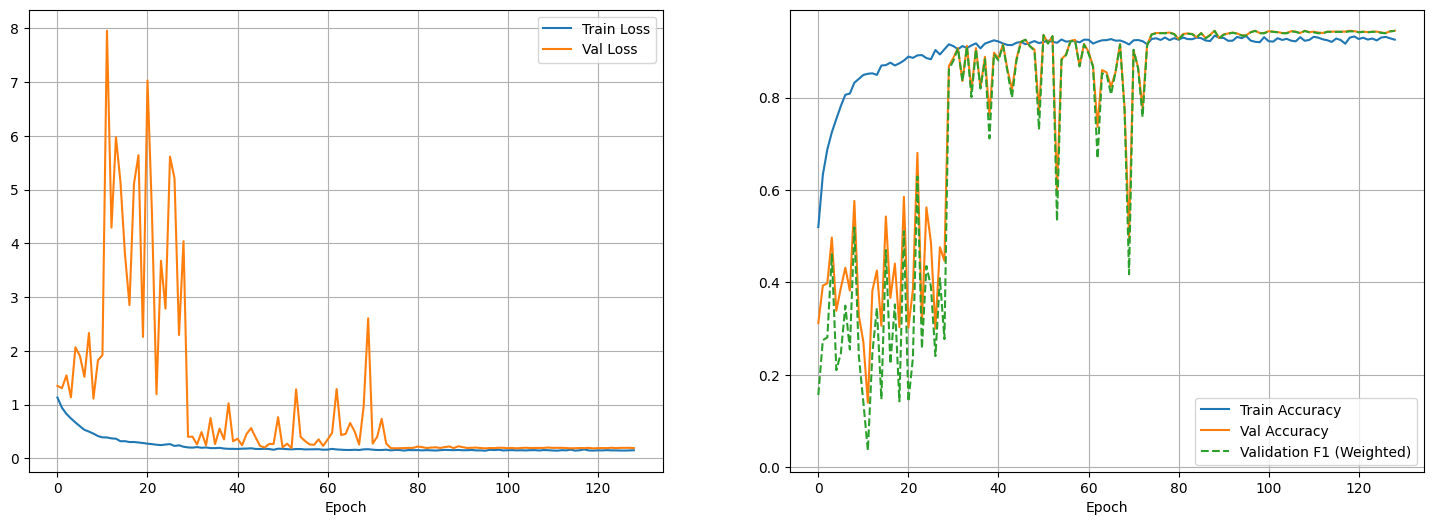


--- ROC Curve Analysis ---


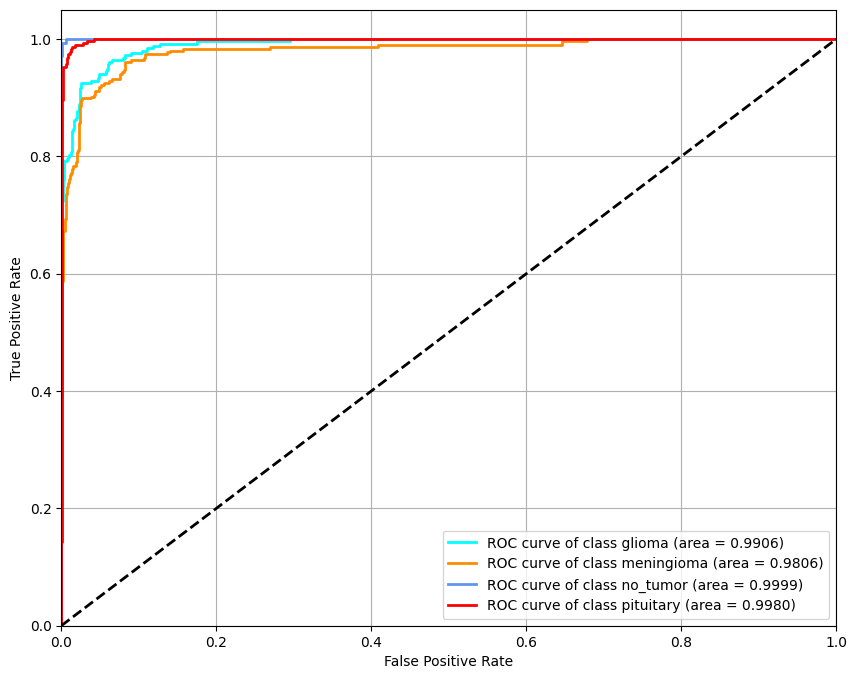


--- Script Finished ---


In [ ]:
# ==============================================================================
# BLOCK 5: EVALUATION
# ==============================================================================

print("\n\n--- Final Evaluation on Test Set ---")
try:
    print(f"Loading best model from: {CLASSIFIER_MODEL_PATH}")
    best_model = models.load_model(
        CLASSIFIER_MODEL_PATH,
        custom_objects={'SpectralFilterLayer': SpectralFilterLayer}
    )

    # --- 1. Evaluating Loss and Accuracy ---
    print("\n--- Calculating Loss and Accuracy on Test Set ---")
    loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss:      {loss:.4f}")
    print(f"Test Accuracy:  {accuracy:.4f}")

    # --- 2. Getting Predictions ---
    y_pred_proba = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)

    # --- 3. Detailed Metrics ---
    print("\n--- Detailed Performance Metrics ---")
    macro_f1 = f1_score(y_test, y_pred_classes, average='macro')
    weighted_f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print(f"Macro F1 Score:   {macro_f1:.4f}")
    print(f"Weighted F1 Score:{weighted_f1:.4f}")

    kappa = cohen_kappa_score(y_test, y_pred_classes)
    mcc = matthews_corrcoef(y_test, y_pred_classes)
    print(f"Cohen's Kappa:    {kappa:.4f}")
    print(f"MCC:              {mcc:.4f}")

    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    print(f"AUC-ROC (Macro):  {auc_roc:.4f}")
    weighted_auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    print(f"AUC-ROC (Weighted):  {weighted_auc_roc:.4f}")

    # --- 4. Classification Report ---
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred_classes, target_names=CLASS_NAMES, digits=4))

    # --- 5. Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # plt.title('SpectraNet-1 on BRISC2025')
    plt.show()

    # --- 6. Plotting Training History ---
    print("\n--- Training History Plots ---")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
    if 'val_f1_weighted' in history.history:
        ax2.plot(history.history['val_f1_weighted'], label='Validation F1 (Weighted)', linestyle='--')
    ax2.set_title('Model Performance')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)
    plt.show()

    # --- 7. ROC Curve Plot ---
    print("\n--- ROC Curve Analysis ---")
    y_test_binarized = label_binarize(y_test, classes=range(len(CLASS_NAMES)))
    n_classes = y_test_binarized.shape[1]
    fpr, tpr, roc_auc_dict = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {CLASS_NAMES[i]} (area = {roc_auc_dict[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred during evaluation: {e}")

print("\n--- Script Finished ---")